In [ ]:
import os
import zipfile
from PIL import Image
import numpy as np
from skimage.metrics import structural_similarity as ssim
import glob
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

#EXTRACT ZIP

In [ ]:
#Load Dataset
data_path = "/content/"

zip_files = ["B_23-20250626T190155Z-1.zip"]
extract_path = "/content/dataset"

os.makedirs(extract_path, exist_ok=True)

for zip_file in zip_files:
    with zipfile.ZipFile(os.path.join(data_path, zip_file), 'r') as zip_ref:
        zip_ref.extractall(extract_path)

#A) EDA

In [ ]:
stats = []

#Open semua image
for root, _, files in os.walk(extract_path):
    for fname in files:
        if fname.lower().endswith((".jpg")):
            fpath = os.path.join(root, fname)

            #Open image PIL
            img = Image.open(fpath)
            arr = np.array(img)

            #Dapatkan info
            height, width = arr.shape[:2]
            channels = 1 if arr.ndim == 2 else arr.shape[2]
            dtype = arr.dtype
            pixel_min = arr.min()
            pixel_max = arr.max()
            pixel_mean = arr.mean()

            stats.append({
                "file": fname,
                "width": width,
                "height": height,
                "channels": channels,
                "dtype": str(dtype),
                "min": pixel_min,
                "max": pixel_max,
                "mean": pixel_mean
            })

#Tampilkan ringkasan untuk 10 file pertama
for s in stats[:10]:
    print(f"{s['file']:30}  {s['width']:4}×{s['height']:4}  "
          f"ch={s['channels']}  dtype={s['dtype']}  "
          f"min={s['min']:.1f}  max={s['max']:.1f}  mean={s['mean']:.3f}")

#Hasil keseluruhan
widths  = [s["width"] for s in stats]
heights = [s["height"] for s in stats]
means   = [s["mean"] for s in stats]

print("\nOverall dataset stats:")
print(f"  Image count : {len(stats)}")
print(f"  Widths  : min={min(widths)}  max={max(widths)}  mean={np.mean(widths):.1f}")
print(f"  Heights : min={min(heights)}  max={max(heights)}  mean={np.mean(heights):.1f}")
print(f"  Pixel means: min={min(means):.3f}  max={max(means):.3f}  mean={np.mean(means):.3f}")

siirt 583.jpg                    600× 600  ch=3  dtype=uint8  min=0.0  max=255.0  mean=57.877
kirmizi 615.jpg                  600× 600  ch=3  dtype=uint8  min=0.0  max=255.0  mean=48.639
kirmizi 583.jpg                  600× 600  ch=3  dtype=uint8  min=0.0  max=255.0  mean=42.643
siirt 827.jpg                    600× 600  ch=3  dtype=uint8  min=0.0  max=255.0  mean=58.506
kirmizi 658.jpg                  600× 600  ch=3  dtype=uint8  min=0.0  max=255.0  mean=40.367
siirt 424.jpg                    600× 600  ch=3  dtype=uint8  min=0.0  max=255.0  mean=54.787
siirt 447.jpg                    600× 600  ch=3  dtype=uint8  min=0.0  max=245.0  mean=41.806
kirmizi 1038.jpg                 600× 600  ch=3  dtype=uint8  min=0.0  max=255.0  mean=51.416
kirmizi 862.jpg                  600× 600  ch=3  dtype=uint8  min=0.0  max=255.0  mean=45.801
kirmizi 916.jpg                  600× 600  ch=3  dtype=uint8  min=0.0  max=255.0  mean=59.046

Overall dataset stats:
  Image count : 1074
  Widths  : min

**Mengetahui keseragaman dimensi:** Semua 1.074 gambar berukuran 600×600 piksel, artinya tidak perlu khawatir tentang variasi resolusi sebelum melakukan resize.

**Memastikan jumlah channel:** Tiap gambar memiliki 3 channel (RGB), jadi model autoencoder harus menerima input bershape (100,100,3) setelah resize.

**Tipe data dan rentang nilai:** Dengan dtype=uint8 dan nilai piksel di antara 0–255, perlu melakukan normalisasi agar training stabil [0-1].

**Distribusi intensitas:** Nilai rata-rata piksel (mean≈48) menunjukkan gambar relatif gelap, ini akan memandu pilihan skema normalisasi dan augmentasi.

**Validasi integritas data:** Tidak ada file corrupt atau dimensi ekstrem, jadi semua gambar dapat diproses seragam tanpa pengecualian.

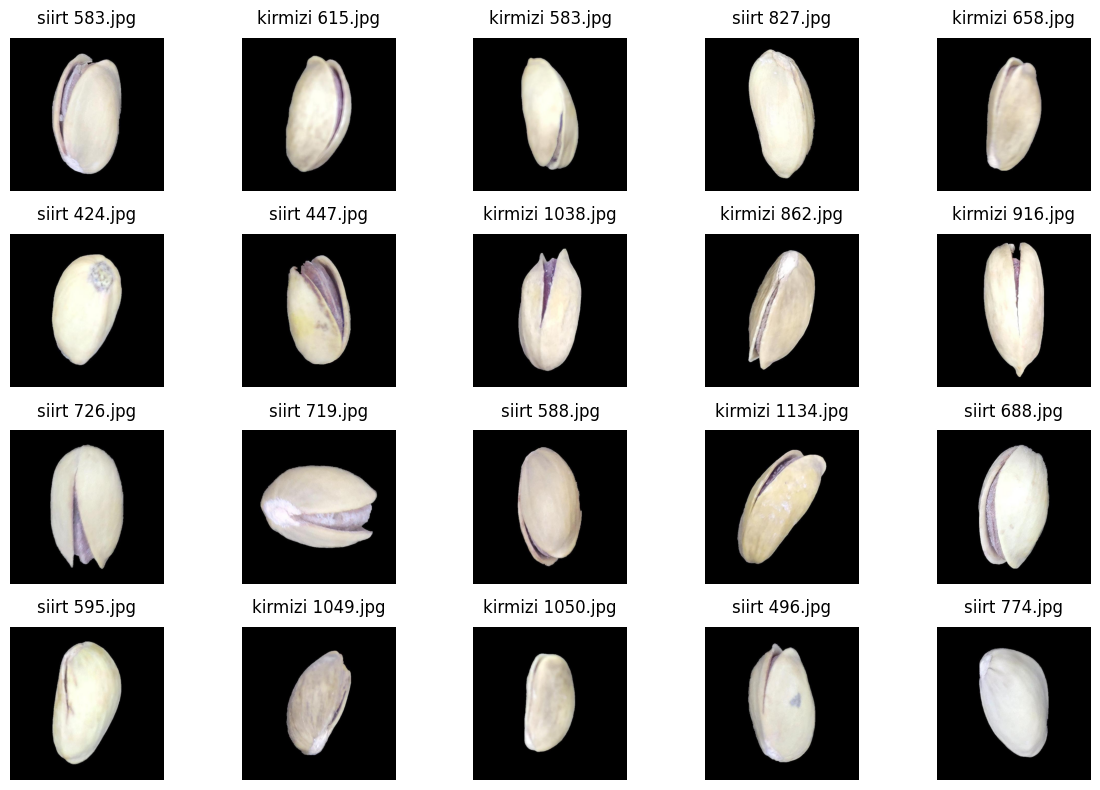

In [ ]:
image_files = glob.glob(os.path.join(extract_path, '**', '*.jpg'), recursive=True)

#Tampilkan 20 data
plt.figure(figsize=(12, 8))
for i, image_file in enumerate(image_files[:20]):
    img = Image.open(image_file)
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.title(os.path.basename(image_file), pad=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

Dari gambar yang ada, dataset ini merupakan data dari kacang pistachio dengan 2 jenis yakni kirmizi dan siirt. Ciri yang terlihat secara visual adalah :


*   **Bentuk :** Pistachio Siirt cenderung memiliki bentuk yang lebih bulat atau oval dan terlihat sedikit lebih gemuk, dibandingkan dengan Pistachio Kirmizi yang cenderung lebih memanjang atau lonjong.

*   **Warna :** Pistachio Siirt cangkangnya tampak lebih terang, cenderung ke arah abu-abu (hampir putih). Pistachio Kirmizi cangkangnya mungkin terlihat sedikit lebih gelap, dengan sedikit nuansa krem / kuning samar



#B) Preprocess Sebelum Model

In [ ]:
#Load semua gambar bersih
images = []
for p in image_files:
    img = cv2.imread(p) #BGR color
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Convert
    images.append(img)
images = np.array(images, dtype="uint8")

#Split 80% train, 10% val, 10% test
train_imgs, temp_imgs = train_test_split(images, test_size=0.2, random_state=42)
val_imgs, test_imgs   = train_test_split(temp_imgs, test_size=0.5, random_state=42)

#Resize semua menjadi 100×100 dan konversi ke float32
def preprocess_batch(batch, size=(100,100)):
    resized = [cv2.resize(img, size) for img in batch]
    arr = np.array(resized, dtype="float32")
    return arr

train_clean = preprocess_batch(train_imgs)
val_clean   = preprocess_batch(val_imgs)
test_clean  = preprocess_batch(test_imgs)

#Normalisasi pixel ke rentang [0,1]
train_clean /= 255.0
val_clean   /= 255.0
test_clean  /= 255.0

#Tambahkan Gaussian noise (μ=0, σ=0.1) dan clip
def add_gaussian_noise(batch, mean=0.0, std=0.1):
    noise = np.random.normal(loc=mean, scale=std, size=batch.shape)
    noisy = batch + noise
    return np.clip(noisy, 0.0, 1.0)

train_noisy = add_gaussian_noise(train_clean)
val_noisy   = add_gaussian_noise(val_clean)
test_noisy  = add_gaussian_noise(test_clean)

#Cek bentuk array akhir
print("train_clean:", train_clean.shape, "train_noisy:", train_noisy.shape)
print("val_clean  :", val_clean.shape,   "val_noisy  :", val_noisy.shape)
print("test_clean :", test_clean.shape,  "test_noisy :", test_noisy.shape)

train_clean: (859, 100, 100, 3) train_noisy: (859, 100, 100, 3)
val_clean  : (107, 100, 100, 3) val_noisy  : (107, 100, 100, 3)
test_clean : (108, 100, 100, 3) test_noisy : (108, 100, 100, 3)


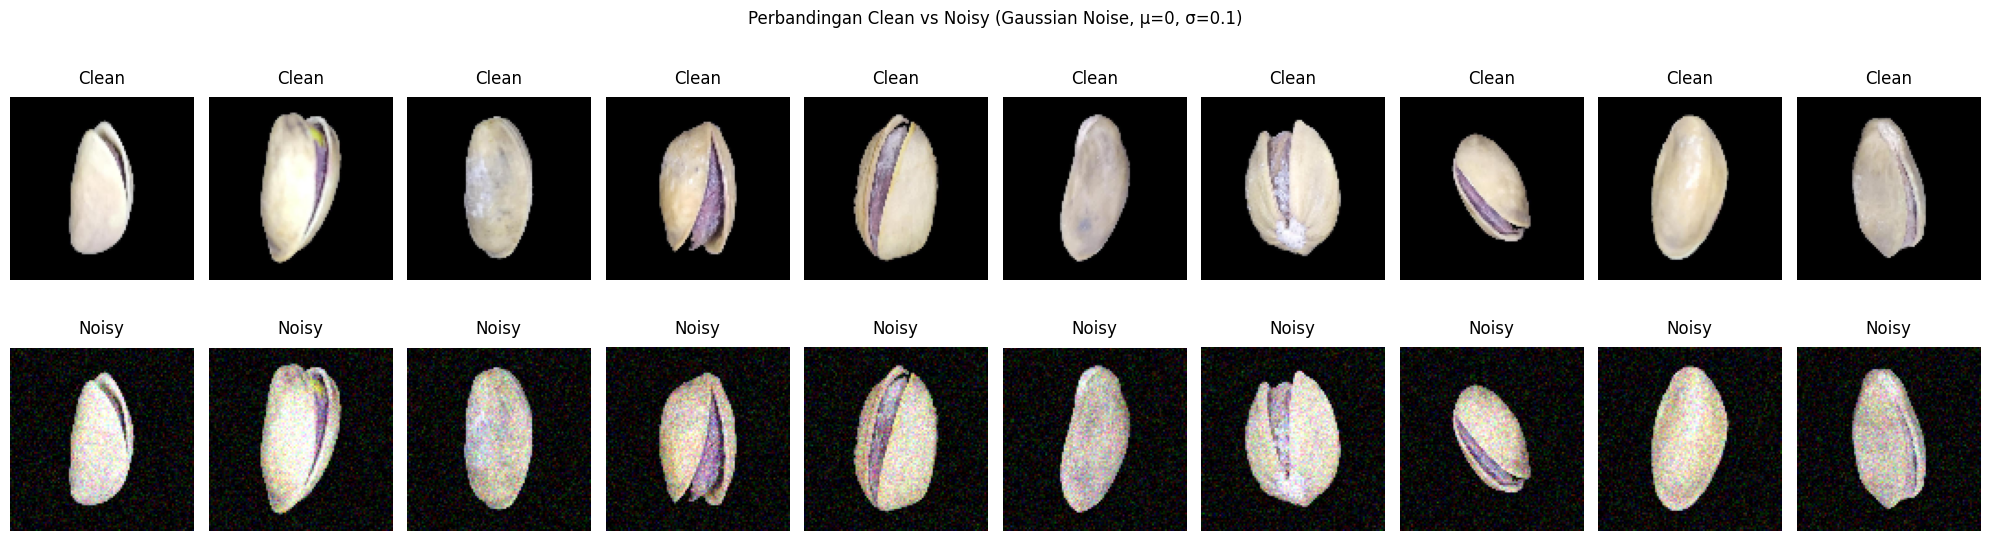

In [ ]:
#Jumlah sampel
n = 10

plt.figure(figsize=(20, 6))
for i in range(n):
    #Gambar clean
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_clean[i])
    plt.title("Clean", pad=10)
    plt.axis('off')

    #Gambar noisy
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(test_noisy[i])
    plt.title("Noisy", pad=10)
    plt.axis('off')

plt.suptitle("Perbandingan Clean vs Noisy (Gaussian Noise, μ=0, σ=0.1)")
plt.tight_layout()
plt.show()

#C) Model

In [ ]:
#Input
input_img = Input(shape=(100, 100, 3))

#Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)  # 100×100×32
x = MaxPooling2D((2, 2), padding='same')(x)                            # 50×50×32
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)          # 50×50×64
encoded = MaxPooling2D((2, 2), padding='same')(x)                      # 25×25×64

#Decoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)    # 25×25×64
x = UpSampling2D((2, 2))(x)                                           # 50×50×64
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)          # 50×50×32
x = UpSampling2D((2, 2))(x)                                           # 100×100×32
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  # 100×100×3

#Model
autoencoder = Model(inputs=input_img, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 100, 100, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = autoencoder.fit(
    train_noisy, train_clean,
    epochs=100,
    batch_size=32,
    validation_data=(val_noisy, val_clean),
    verbose=2
)

Epoch 1/100
27/27 - 10s - 360ms/step - loss: 0.0697 - val_loss: 0.0130
Epoch 2/100
27/27 - 3s - 102ms/step - loss: 0.0205 - val_loss: 0.0201
Epoch 3/100
27/27 - 1s - 21ms/step - loss: 0.0160 - val_loss: 0.0137
Epoch 4/100
27/27 - 1s - 22ms/step - loss: 0.0130 - val_loss: 0.0128
Epoch 5/100
27/27 - 1s - 28ms/step - loss: 0.0121 - val_loss: 0.0114
Epoch 6/100
27/27 - 1s - 43ms/step - loss: 0.0069 - val_loss: 0.0043
Epoch 7/100
27/27 - 1s - 24ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 8/100
27/27 - 1s - 45ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 9/100
27/27 - 1s - 21ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 10/100
27/27 - 1s - 23ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 11/100
27/27 - 1s - 22ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 12/100
27/27 - 1s - 21ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 13/100
27/27 - 1s - 23ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 14/100
27/27 - 1s - 23ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 15/100
27/27 - 1s - 

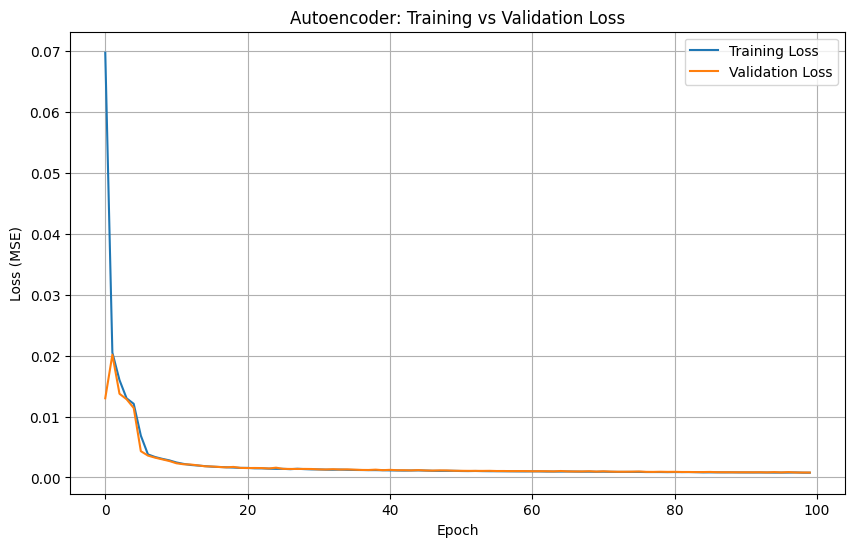

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'],   label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder: Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

Dari plot bisa dilihat bahwa model sudah konvergen namun ada kenaikan mendadak diawal

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step


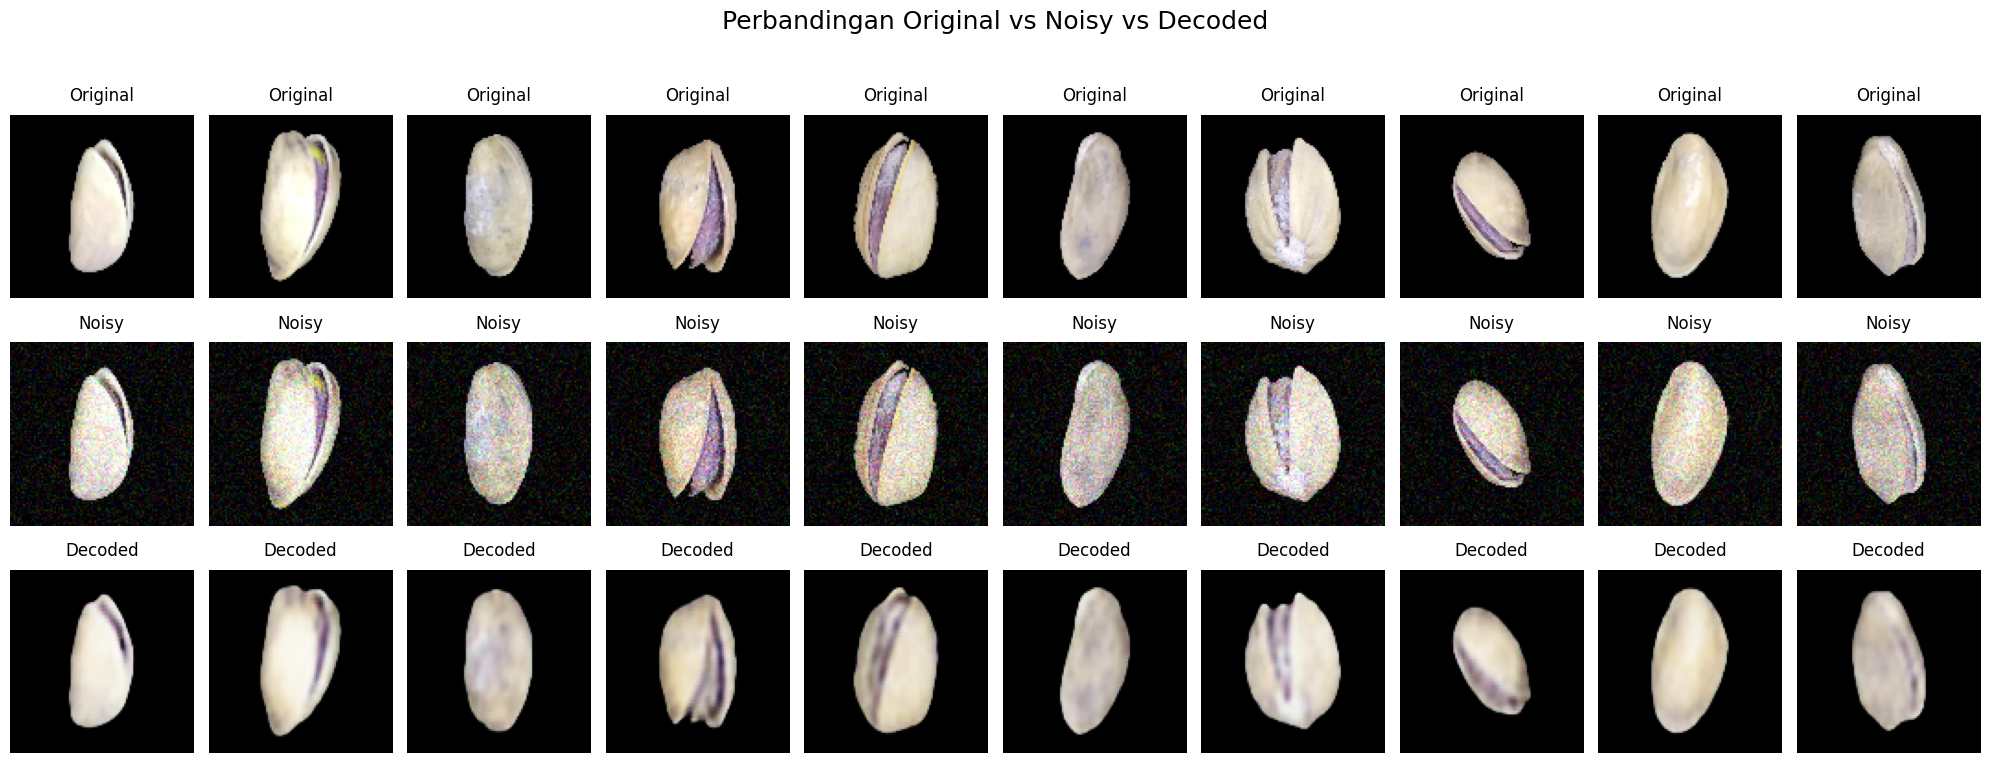

In [ ]:
decoded_imgs = autoencoder.predict(test_noisy)
n = 10
plt.figure(figsize=(20, 8))

for i in range(n):
    #Original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(test_clean[i])
    plt.title("Original", pad=10)
    plt.axis('off')

    #Noisy
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(test_noisy[i])
    plt.title("Noisy", pad=10)
    plt.axis('off')

    #Decoded
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs[i])
    plt.title("Decoded", pad=10)
    plt.axis('off')

plt.suptitle("Perbandingan Original vs Noisy vs Decoded", fontsize=18)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()


Bisa dilihat juga gambar hasil decodednya sudah mirip dengan yang aslinya namun masih bisa ditingkatkan lagi

#D) Modifikasi

In [ ]:
#Input
input_img_mod = Input(shape=(100, 100, 3))

#Encoder
x = Conv2D(32, (3, 3), padding='same')(input_img_mod)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(64, (3, 3), padding='same')(x)
x = LeakyReLU(alpha=0.1)(x)
encoded_mod = MaxPooling2D((2, 2), padding='same')(x)

#Decoder
x = Conv2D(64, (3, 3), padding='same')(encoded_mod)
x = LeakyReLU(alpha=0.1)(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(32, (3, 3), padding='same')(x)
x = LeakyReLU(alpha=0.1)(x)
x = UpSampling2D((2, 2))(x)

#Output layer
decoded_mod = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

#Model
autoencoder_mod = Model(inputs=input_img_mod, outputs=decoded_mod)
autoencoder_mod.compile(optimizer='adam', loss='mse')

#Summary
autoencoder_mod.summary()

#EarlyStopping
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 25, 25, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 50, 50, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 100, 100, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_mod = autoencoder_mod.fit(
    train_noisy, train_clean,
    epochs=100,
    batch_size=32,
    validation_data=(val_noisy, val_clean),
    callbacks=[es],
    verbose=2
)

Epoch 1/100
27/27 - 6s - 228ms/step - loss: 0.0608 - val_loss: 0.0129
Epoch 2/100
27/27 - 1s - 26ms/step - loss: 0.0086 - val_loss: 0.0046
Epoch 3/100
27/27 - 1s - 43ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 4/100
27/27 - 1s - 23ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 5/100
27/27 - 1s - 23ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 6/100
27/27 - 1s - 23ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 7/100
27/27 - 1s - 23ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 8/100
27/27 - 1s - 23ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 9/100
27/27 - 1s - 22ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 10/100
27/27 - 1s - 23ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 11/100
27/27 - 1s - 24ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 12/100
27/27 - 1s - 23ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 13/100
27/27 - 1s - 23ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 14/100
27/27 - 1s - 24ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 15/100
27/27 - 1s - 24

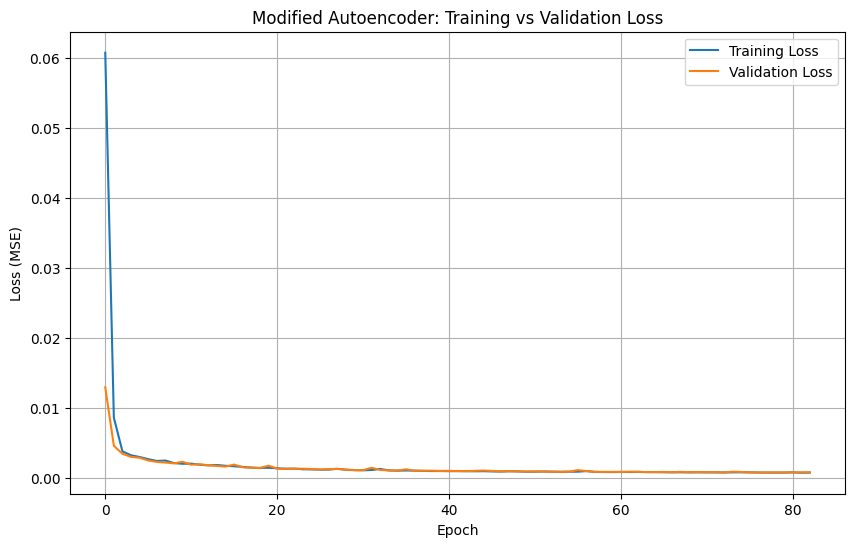

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history_mod.history['loss'], label='Training Loss')
plt.plot(history_mod.history['val_loss'], label='Validation Loss')
plt.title('Modified Autoencoder: Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

Dari plot dapat dikatakan model modifikasi lama kelamaan menjadi konvergen dan tidak ada peningkatan mendadak

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


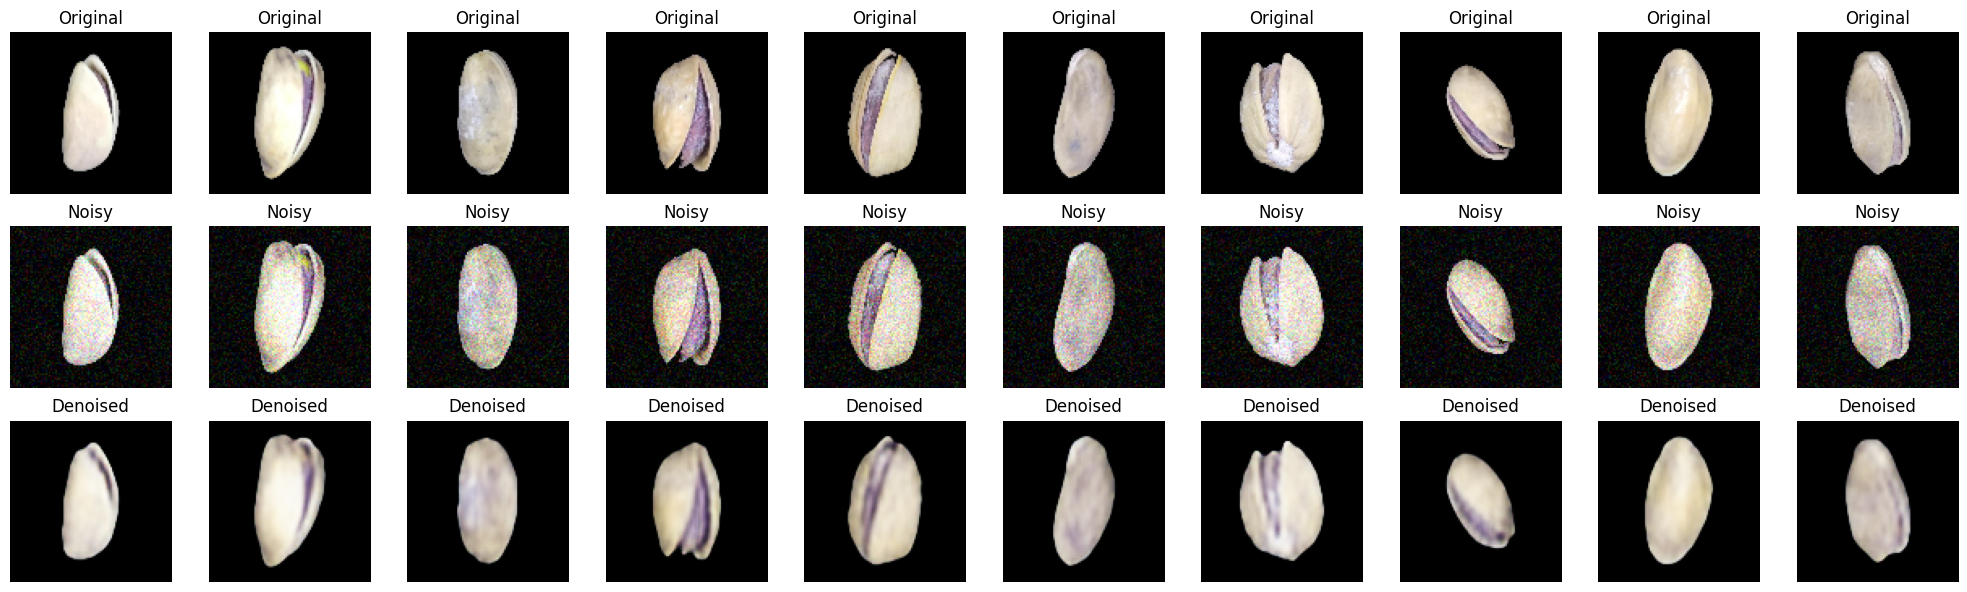

In [ ]:
#Predict
decoded_imgs_mod = autoencoder_mod.predict(test_noisy)

#Tampilkan hasil
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    #clean
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(test_clean[i])
    plt.title("Original")
    plt.axis('off')

    #noisy
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(test_noisy[i])
    plt.title("Noisy")
    plt.axis('off')

    #reconstructed
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_imgs_mod[i])
    plt.title("Denoised")
    plt.axis('off')
plt.tight_layout()
plt.show()

Dari hasil bisa dilihat bahwa hasilnya menyerupai bentuk awal dan warnanya sudah hampir menyerupai juga

#E) Evaluasi

In [ ]:
def evaluate_ssim(y_true, y_pred):
    scores = []
    for i in range(len(y_true)):
        score = ssim(y_true[i], y_pred[i], channel_axis=-1, data_range=1.0)
        scores.append(score)
    return np.mean(scores)

In [ ]:
decoded_imgs = autoencoder.predict(test_noisy)

y_true = test_clean.flatten()
y_pred = decoded_imgs.flatten()

ssim_score = evaluate_ssim(test_clean, decoded_imgs)
print(f"Rata-rata SSIM Model Awal: {ssim_score:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Rata-rata SSIM Model Awal: 0.9498


**SSIM > 0.90:** Dapat diartikan bahwa model baseline sudah menghasilkan decode yang sangat mirip dengan kualitas bagus

In [ ]:
decoded_imgs_mod = autoencoder_mod.predict(test_noisy)

y_true = test_clean.flatten()
y_pred = decoded_imgs_mod.flatten()

ssim_score = evaluate_ssim(test_clean, decoded_imgs_mod)
print(f"Rata-rata SSIM Model Modifikasi: {ssim_score:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Rata-rata SSIM Model Modifikasi: 0.9521


Nilai SSIM rata-rata = 0.9521 pada model modifikasi menunjukkan performa yang cukup baik dan mengalami peningkatan dibanding model sebelumnya (yang sebelumnya 0.9498). Artinya model modifikasi lebih cocok.

**Kesimpulan :** Model modifikasi lebih baik, dapat dilihat juga dari hasil gambar yang dihasilkan dan juga hasil SSIM yang lebih tinggi dibandingkan model modifikasi